# K-means Clustering 

* We will start with a sample dataset that will help demontrate the intuition of how the K-means algorithm works. 
* After that, we will use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.


# Outline
- [ 1 - Implementing K-means](#1)
  - [ 1.1 Finding closest centroids](#1.1)
  - [ 1.2 Computing centroid means](#1.2)
- [ 2 - K-means on a sample dataset ](#2)
- [ 3 - Random initialization](#3)
- [ 4 - Image compression with K-means](#4)
  - [ 4.1 Dataset](#4.1)
  - [ 4.2 K-Means on image pixels](#4.2)
  - [ 4.3 Compress the image](#4.3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

<a name="1"></a>
## 1 - Implementing K-means

The K-means algorithm is a method to automatically cluster similar
data points together. 

* Concretely, you are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and we want
to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps:
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $x^{(i)}$ to its closest
centroid, given the current positions of centroids. 

The first task is `find_closest_centroids`. 

* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{1,...,K\}$, where $K$ is total number of centroids) to every training example .
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)

In [ ]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example

    Args:
        X (ndarray): (m, n) Input values
        centroids (ndarray): k centroids

    Returns:
        idx (array_like): (m,) closest centroids

    """

    # Set K (number of centroids)
    K = centroids.shape[0]

    # Initialize output container
    # Note that sum(axis=2) is the same as np.linalg.norm((X - centroids[:, np.newaxis])**2, axis=2)
    norm_squared = ((X - centroids[:, np.newaxis]) ** 2).sum(axis=2)

    # Find the index of the closest centroid for each example by finding the minimum along the first axis (k, m, n)
    # This finds index of the smallest squared norms amongs the k candidates
    idx = np.argmin(norm_squared, axis=0)

    return idx

The implementation above uses numpy broadcasting, which is a powerful feature of NumPy that allows us to perform arithmetic operations between arrays with different shapes. The broadcasting is used here to calculate the difference between each example (a row in `X[i, :]`) and each centroid (`centroids[i]`) in one step. 

By adding a new axis to centroids using `[:, np.newaxis]`, we create a new dimension at position `1` with size `1`, so the shape of `centroids[:, np.newaxis]` is now `(k, 1, n)` instead of `(k, n)`. This allows NumPy to broadcast the centroids along this new dimension to match the shape of `X - centroids[:, np.newaxis]`, which has shape `(m, n) - (k, 1, n) = (k, m, n)`. The resulting array contains the difference between each example and each centroid in one step, which is then squared and summed to obtain the squared norm.

In [80]:
# X has shape (3, 2)
exp_X = np.array([[1, 2], [3, 4], [5, 6]])
# Centroids has shape (2, 2)
exp_centroids = np.array([[0, 0], [1, 1]])

exp_X, exp_centroids

(array([[1, 2],
        [3, 4],
        [5, 6]]),
 array([[0, 0],
        [1, 1]]))

In [83]:
# Subtract centroids from X using broadcasting
diff = exp_X - exp_centroids[:, np.newaxis]

diff.shape

(2, 3, 2)

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* The overall implementation for this function
    ```python 
    def find_closest_centroids(X, centroids):
    
        # Set K
        K = centroids.shape[0]
    
        idx = np.zeros(X.shape[0], dtype=int)
    
        ### START CODE HERE ###
        for i in range(X.shape[0]):
            # Array to hold distance between X[i] and each centroids[j]
            distance = [] 
            for j in range(centroids.shape[0]):
                norm_ij = # Calculate the norm between (X[i] - centroids[j])
                distance.append(norm_ij)
            
            idx[i] = # Calculate index of minimum value in distance
        ### END CODE HERE ###
        return idx
    ```
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate norm_ij</b></font></summary>
           &emsp; &emsp; Use <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html">np.linalg.norm</a> to calculate the norm 
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate norm_ij</b></font></summary>
               &emsp; &emsp; Compute norm_ij as <code>norm_ij = np.linalg.norm(X[i] - centroids[j]) </code>
           </details>
    </details>

     <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate idx[i]</b></font></summary>
          &emsp; &emsp; Use <a href="https://numpy.org/doc/stable/reference/generated/numpy.argmin.html">np.argmin</a> to find the index of the minimum value
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate idx[i]</b></font></summary>
              &emsp; &emsp; Compute idx[i] as <code>idx[i] = np.argmin(distance)</code>
          </details>
    </details>
        
    </details>

</details>

    


In [64]:
# Load an example dataset that we will be using
X = load_data()

The code below prints the first five elements in the variable `X` and the dimensions of the variable

In [147]:
# Select an initial set of centroids (3 Centroids)
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])

First three elements in idx are: [0 2 1]


<a name="1.2"></a>
### 1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the
algorithm recomputes, for each centroid, the mean of the points that
were assigned to it.

* Specifically, for every centroid $\mu_k$ we set
$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

where 

  * $C_k$ is the set of examples that are assigned to centroid $k$
  * $|C_k|$ is the number of examples in the set $C_k$


Concretely, if two examples (rows in a data matrix) say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then we should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$

In [152]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the
    data points assigned to each centroid.

    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each
                       example in X. Concretely, idx[i] contains the index of
                       the centroid closest to example i
        K (int):       number of centroids

    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    m, n = X.shape

    # Create a binary mask for each centroid (a matrix of 1's and 0's with shape (m, k))
    # The == is broadcasted for each cluster label in `np.arange(K)`
    # Each row in matrix 'mask' has only one true among 'K' columns, e.g., (True, False, ...., False)
    mask = (idx[:, np.newaxis] == np.arange(K)).astype(float)

    # Compute the sum of data points assigned to each centroid--- (k, m) X (m, n) = (k, n)
    # Each of the k rows of maks.T is a (m, 1) vector of 1 (in cluster k) or 0 (not in cluster k)
    sum_points = mask.T @ X

    # Compute the number of data points assigned to each centroid with shape (k,)
    num_points = mask.sum(axis=0)  # Sum down the rows

    # Compute the new centroids as the mean of the assigned data points
    centroids = sum_points / num_points[:, np.newaxis]

    return centroids

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* The overall implementation for this function
    ```python 
    def compute_centroids(X, idx, K):
        # Useful variables
        m, n = X.shape
    
        centroids = np.zeros((K, n))
    
        ### START CODE HERE ###
        for k in range(K):   
            points = # Get a list of all data points in X assigned to centroid k  
            centroids[k] = # Compute the mean of the points assigned
    ### END CODE HERE ## 
    
    return centroids
    ```
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate points</b></font></summary>
           &emsp; &emsp; Say we wanted to find all the values in X that were assigned to cluster <code>k=0</code>. That is, the corresponding value in idx for these examples is 0. In Python, we can do it as <code>X[idx == 0]</code>. Similarly, the points assigned to centroid <code>k=1</code> are <code>X[idx == 1]</code>
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate points</b></font></summary>
               &emsp; &emsp; Compute points as <code>points = X[idx == k] </code>
           </details>
    </details>

     <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate centroids[k]</b></font></summary>
          &emsp; &emsp; Use <a href="https://numpy.org/doc/stable/reference/generated/numpy.mean.html">np.mean</a> to find the mean. Make sure to set the parameter <code>axis=0</code> 
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate centroids[k]</b></font></summary>
              &emsp; &emsp; Compute centroids[k] as <code>centroids[k] = np.mean(points, axis = 0)</code>
          </details>
    </details>
        
    </details>

</details>

    


The implementation again used broadcasting. 

1. First, let's consider the expression `idx[:, np.newaxis]`. The original `idx` array has shape `(m,)`, which means it is a 1-dimensional array. By adding a new axis with `np.newaxis`, we obtain a new array with shape `(m, 1)`. This can be useful in many cases where we need to perform operations between arrays of different shapes.

2. Next, we create an array of integers from 0 to K-1 using `np.arange(K)`. This array has shape `(K,)`, which means it is a 1-dimensional array. We then use the `==` operator to compare the `idx[:, np.newaxis]` array with this new array--- i.e., we compare shapes `(m, 1)` and `(K, )`. The result is a boolean array of shape `(m, K)` where each element `(i, j)` is True if `idx[i] == j` and `False` otherwise.

3. Next, we use the `astype` method to convert the boolean array to a `float` array of the same shape, where `True` values are converted to 1.0 and `False` values are converted to 0.0. The resulting mask array has shape `(m, K)` and is a binary matrix where each row contains exactly one 1.0 and all other elements are 0.0. Each 1.0 in the mask matrix indicates that the corresponding example in X is assigned to the cluster with label `j` amongst `K` clusters.

4. Then, `mask` is a binary array of shape `(m, K)` that indicates which centroid (cluster) each example in `X` is assigned to. Specifically, `mask[i, j]` is equal to 1 if example `i` is assigned to centroid `j`, and 0 otherwise. We transpose `mask` using the `.T` attribute to obtain a binary array of shape `(K, m)`, where each row `j` indicates which examples (row indices to `X`) are assigned to centroid `j`. We then multiply this transposed binary array by `X` using the `@` operator. This matrix multiplication results in an array of shape `(K, n)`, where each row `j` contains the sum of the examples assigned to centroid `j`.

5. Finally, we use broadcasting to divide each row of `sum_points` by the corresponding value in `num_points`. Specifically, we divide each row `j` of `sum_points` ($K \times n$) by the scalar value `num_points[j]`, which we obtain by selecting the j-th element of `num_points`. To do this, we use the `[:, np.newaxis]` syntax to add a new axis to `num_points`, which converts it from a 1D array of shape `(K,)` to a 2D array of shape `(K, 1)`. This allows us to perform the division using broadcasting, which automatically applies the operation element-wise across the two arrays. The result is an array of shape `(K, n)` containing the mean position of the data points assigned to each centroid.

In [154]:
K = 3
centroids = compute_centroids(X, idx, K)

print("The centroids are:", centroids)

The centroids are: [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


<a name="2"></a>
## 2 - K-means on a sample dataset 

In [155]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """

    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)

    # Run K-Means
    for i in range(max_iters):
        # Output progress
        print("K-Means iteration %d/%d" % (i, max_iters - 1))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)

        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids

        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show()
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


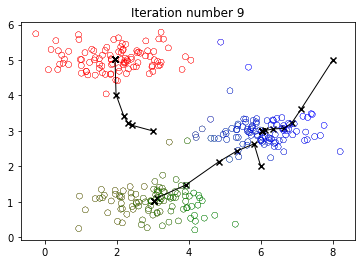

In [156]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
K = 3

# Number of iterations
max_iters = 10

centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

<a name="3"></a>
## 3 - Random initialization

In practice, a good strategy for initializing the centroids is to select random examples from the
training set.

* The code below first randomly shuffles the indices of the examples (using `np.random.permutation()`). 
* Then, it selects the first $K$ examples based on the random permutation of the indices. 
    * This allows the examples to be selected at random without the risk of selecting the same example twice.

In [157]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be
    used in K-Means on the dataset X

    Args:
        X (ndarray): Data points
        K (int):     number of centroids/clusters

    Returns:
        centroids (ndarray): Initialized centroids
    """

    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K]]

    return centroids

<a name="4"></a>
## 4 - Image compression with K-means 

* In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding.
* Our image contains thousands of colors, and in this part of the exercise, we will reduce the number of
colors to 16 colors.
* By making this reduction, it is possible to represent (compress) the photo in an efficient way. 
* Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

We will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.
* Concretely, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space. 
* Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

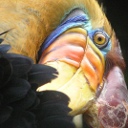

$^{2}$<sub>The provided photo used in this exercise belongs to Frank Wouters and is used with his permission.</sub>

<a name="4.1"></a>
### 4.1 Dataset

**Load image**

First, we will use `matplotlib` to read in the original image, as shown below.

In [176]:
# Load an image of a bird
original_img = plt.imread("bird_small.png")

**Visualize image**

You can visualize the image that was just loaded using the code below.

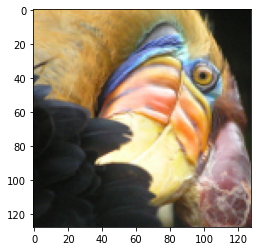

In [177]:
# Visualizing the image
plt.imshow(original_img)

**Check the dimension of the variable**

In [178]:
print("Shape of original image is:", original_img.shape)

Shape of original image is: (128, 128, 3)


This creates a three-dimensional matrix `original_img` where 

* the first two indices identify a pixel position
* the third index represents red, green, or blue. 

For example, `original_img[50, 33, 2]` gives the blue intensity of the pixel at row 50 and column 33.

#### Processing data

To call the `run_kMeans`, we need to first transform the matrix `original_img` into a two-dimensional matrix.

* The code below reshapes the matrix `original_img` to create an $m \times 3$ matrix of pixel colors (where
$m=16384 = 128\times128$)

In [179]:
# Divide by 255 so that all values are in the range 0 - 1
original_img = original_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.
X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))
X_img.shape

(16384, 3)

In [180]:
X_img[:3]

array([[0.00336794, 0.00276817, 0.00158401],
       [0.0035371 , 0.00284506, 0.00178393],
       [0.00347559, 0.00286044, 0.00169166]], dtype=float32)

<a name="4.2"></a>
### 4.2 K-Means on image pixels

Run K-Means on the pre-processed image.

In [181]:
K = 16
max_iters = 10

# Create initial centroids
initial_centroids = kMeans_init_centroids(X_img, K)

centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


In [182]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [5 5 5 5 5]


The 16 centroids are as follows, each of wich is a three-dimensional vector:

In [183]:
centroids

array([[0.00039157, 0.00042257, 0.0003822 ],
       [0.00278411, 0.00220629, 0.00128124],
       [0.00058129, 0.0006033 , 0.00057047],
       [0.00156708, 0.00124867, 0.00103438],
       [0.00029461, 0.00031925, 0.00027721],
       [0.00337695, 0.00279567, 0.00178119],
       [0.00022491, 0.00024653, 0.00020927],
       [0.00382352, 0.00371344, 0.00322282],
       [0.00232859, 0.00168887, 0.00077572],
       [0.00192777, 0.00174787, 0.00177525],
       [0.00320163, 0.00290869, 0.00287434],
       [0.00378041, 0.00337581, 0.00249568],
       [0.00206159, 0.00256815, 0.00324551],
       [0.00266   , 0.00236245, 0.00211816],
       [0.00346808, 0.00230384, 0.00104986],
       [0.00094835, 0.00088038, 0.00086371]])

<a name="4.3"></a>
### 4.3 Compress the image


After finding the top $K=16$ colors to represent the image, we can now assign each pixel position to its closest centroid using the `find_closest_centroids` function. 

* This allows us to represent the original image using the centroid assignments of each pixel. 
* Notice that we have significantly reduced the number of bits that are required to describe the image. 

    * The original image required 24 bits for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. 
    * The new representation requires some overhead storage in the form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

In [184]:
# Represent image in terms of indices
X_recovered = centroids[idx, :]

# Reshape recovered image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape)

Finally, we can view the effects of the compression by reconstructing
the image based only on the centroid assignments. 

* Specifically, we can replace each pixel location with the value of the centroid assigned to it. Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.


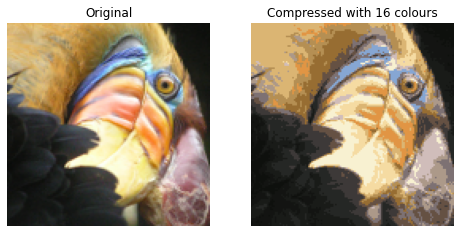

In [186]:
# Display original image
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
plt.axis("off")

ax[0].imshow(original_img * 255)
ax[0].set_title("Original")
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered * 255)
ax[1].set_title("Compressed with %d colours" % K)
ax[1].set_axis_off()